# Sparse covariance estimation for Gaussian variables

A derivative work by Judson Wilson, 5/22/2014.<br>
Adapted (with significant improvements and fixes) from the CVX example of the same name, by Joelle Skaf, 4/24/2008.

Topic References:

* Section 7.1.1, Boyd & Vandenberghe "Convex Optimization" 

## Introduction

Suppose $y \in \mathbf{\mbox{R}}^n$ is a Gaussian random variable with zero mean and
covariance matrix $R = \mathbf{\mbox{E}}[yy^T]$, with sparse inverse $S = R^{-1}$
($S_{ij} = 0$ means that $y_i$ and $y_j$ are conditionally independent).
We want to estimate the covariance matrix $R$ based on $N$ independent
samples $y_1,\dots,y_N$ drawn from the distribution, and using prior knowledge
that $S$ is sparse

A good heuristic for estimating $R$ is to solve the problem
  $$\begin{array}{ll}
    \mbox{maximize}   & \log \det(S) - \mbox{tr}(SY) \\
    \mbox{subject to} & \sum_{i=1}^n \sum_{j=1}^n |S_{ij}| \le \alpha \\
                      & S \succeq 0,
    \end{array}$$
where $Y$ is the sample covariance of $y_1,\dots,y_N$, and $\alpha$ is a sparsity
parameter to be chosen or tuned.

## Generate problem data

In [1]:
import cvxpy as cp
import numpy as np
import scipy as scipy

# Fix random number generator so we can repeat the experiment.
np.random.seed(0)

# Dimension of matrix.
n = 10

# Number of samples, y_i
N = 1000

# Create sparse, symmetric PSD matrix S
A = np.random.randn(n, n)  # Unit normal gaussian distribution.
A[scipy.sparse.random_array((n, n), density=0.85).todense().nonzero()] = 0  # Sparsen A
Strue = A.dot(A.T) + 0.05 * np.eye(n)  # Force strict pos. def.

# Create the covariance matrix associated with S.
R = np.linalg.inv(Strue)

# Create samples y_i from the distribution with covariance R. 
y_sample = scipy.linalg.sqrtm(R).dot(np.random.randn(n, N))

# Calculate the sample covariance matrix.
Y = np.cov(y_sample)

## Solve for several $\alpha$ values

In [2]:
# The alpha values for each attempt at generating a sparse inverse cov. matrix.
alphas = [10, 2, 1]

# Empty list of result matrixes S
Ss = []

# Solve the optimization problem for each value of alpha.
for alpha in alphas:
    # Create a variable that is constrained to the positive semidefinite cone.
    S = cp.Variable(shape=(n,n), PSD=True)
    
    # Form the logdet(S) - tr(SY) objective. Note the use of a set
    # comprehension to form a set of the diagonal elements of S*Y, and the
    # native sum function, which is compatible with cvxpy, to compute the trace.
    # TODO: If a cvxpy trace operator becomes available, use it!
    obj = cp.Maximize(cp.log_det(S) - sum([(S*Y)[i, i] for i in range(n)]))
    
    # Set constraint.
    constraints = [cp.sum(cp.abs(S)) <= alpha]
    
    # Form and solve optimization problem
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.CVXOPT)
    if prob.status != cp.OPTIMAL:
        raise Exception('CVXPY Error')

    # If the covariance matrix R is desired, here is how it to create it.
    R_hat = np.linalg.inv(S.value)
    
    # Threshold S element values to enforce exact zeros:
    S = S.value
    S[abs(S) <= 1e-4] = 0

    # Store this S in the list of results for later plotting.
    Ss += [S]

    print('Completed optimization parameterized by alpha = {}, obj value = {}'.format(alpha, obj.value))

Completed optimization parameterized by alpha = 10, obj value = -16.167608186713004
Completed optimization parameterized by alpha = 2, obj value = -22.545759632606043
Completed optimization parameterized by alpha = 1, obj value = -26.989407069609157


## Result plots

<Figure size 432x288 with 0 Axes>

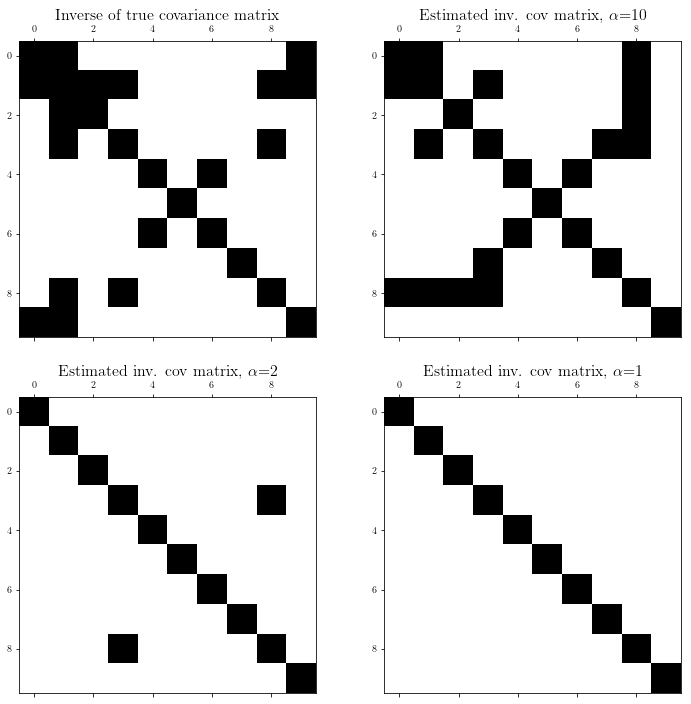

In [3]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create figure.
plt.figure()
plt.figure(figsize=(12, 12))

# Plot sparsity pattern for the true covariance matrix.
plt.subplot(2, 2, 1)
plt.spy(Strue)
plt.title('Inverse of true covariance matrix', fontsize=16)

# Plot sparsity pattern for each result, corresponding to a specific alpha.
for i in range(len(alphas)):
    plt.subplot(2, 2, 2+i)
    plt.spy(Ss[i])
    plt.title('Estimated inv. cov matrix, $\\alpha$={}'.format(alphas[i]), fontsize=16)